## 01. XGBoost Tuning for Aerial LiDAR Data Classification

<br>

__LiDAR__, which stands for Light Detection and Ranging, is a remote sensing method that uses light in the form of a pulsed laser to measure ranges to the Earth. These light pulses—combined with other data recorded by the airborne system— generate precise, three-dimensional information about the shape of the Earth and its surface characteristics.

The aim of the thesis is to choose and optimize a machine learning algorithm to perform classification of aerial laser skanning data into classes using avaliable features from __*.LAS__ format data.

For the purpose of the project the data was firstly converted to __*.csv__ format with __ArcGIS PRO 2.1.1__ software.

<img src="img/LAS_dataset.png" width="80%">
Source: http://pro.arcgis.com/en/pro-app/help/data/las-dataset/GUID-C323587E-81F2-4823-B2E4-2331445BF5D1-web.png


<br>

### Table of Contents

    1.Train / test dataset

        1.1 Data analysis
        1.2 Data sampling
        1.3 XGBoost - default
        1.4 XGBoost - tuning
    
    2.Test dataset
    
        2.1 Data analysis
        2.2 XGBoost - default
        2.3 XGBoost - tuned




## 1.Train / test dataset
### 1.1 Data analysis

The dataset composes of two areas - one for training / testing and one for final independent accuracy testing. They all cover a selected area of Peplin municipality.


<img src="img/Zakres1_2_2d.jpg" width="80%">


First subject consists of 268 523 LiDAR points located over 41 379 square meters.


<img src='img/Zakres1_2d.jpg' width="80%">
<img src='img/Zakres1_3d.jpg' width="80%">


In the next steps we will read and analyze the __Train_Test_Area.csv__ data

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
tt_area = pd.read_csv('data/01.Train_Test_Area.csv', header=0, delimiter=' ')
tt_area.head(10)

,X,Y,Z,R,G,B,PointSourceId,ScanAngleRank,ScanDirectionFlag,NumberOfReturns,ReturnNumber,Intensity,Classification
0,484179.43750,676279.6875,49.340000,124,124,112,101.0,-25.0,1.0,1.0,1.0,64.0,12.0
1,484179.31250,676280.0000,49.320000,124,125,115,101.0,-25.0,1.0,1.0,1.0,60.0,12.0
2,484178.81250,676280.0625,49.310001,123,124,113,101.0,-25.0,1.0,1.0,1.0,62.0,12.0
3,484178.31250,676280.1250,49.340000,122,122,112,101.0,-25.0,1.0,1.0,1.0,64.0,12.0
4,484177.81250,676280.1875,49.320000,122,122,112,101.0,-25.0,1.0,1.0,1.0,70.0,12.0
5,484177.31250,676280.1875,49.320000,125,125,115,101.0,-25.0,1.0,1.0,1.0,63.0,12.0
6,484176.84375,676280.2500,49.310001,124,124,115,101.0,-25.0,1.0,1.0,1.0,63.0,12.0
7,484176.31250,676280.2500,49.340000,125,125,117,101.0,-25.0,1.0,1.0,1.0,57.0,12.0
8,484179.12500,676280.3750,49.310001,124,126,115,101.0,-25.0,1.0,1.0,1.0,54.0,12.0
9,484178.65625,676280.3750,49.320000,128,129,119,101.0,-25.0,1.0,1.0,1.0,58.0,12.0


__LiDAR__ per-point data attriubtes definition:
 
__X__,__Y__ - The planimetric ground location of the point,

__Z__ - The elevation of the point,

__R__,__G__,__B__ - Additive color model values,

__PointSourceId__ - A unique identifier to reference this point back to a collection source,

__ScanAngleRank__ - Angle at which the laser point was output from the laser system including the roll of the aircraft,

__ScanDirectionFlag__ - Direction the laser scanning mirror was traveling at the time of the output laser pulse,

__NumberOfReturns__ - Number of returns detected for a given transmitted pulse,

__Intensity__ - The laser pulse return intensity at the sensor,

__Classification__ - Surface attribute assigned to this point such as ground, vegetation.

In [3]:
tt_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268523 entries, 0 to 268522
Data columns (total 13 columns):
X                    268523 non-null float64
Y                    268523 non-null float64
Z                    268523 non-null float64
R                    268523 non-null int64
G                    268523 non-null int64
B                    268523 non-null int64
PointSourceId        268523 non-null float64
ScanAngleRank        268523 non-null float64
ScanDirectionFlag    268523 non-null float64
NumberOfReturns      268523 non-null float64
ReturnNumber         268523 non-null float64
Intensity            268523 non-null float64
Classification       268523 non-null float64
dtypes: float64(10), int64(3)
memory usage: 26.6 MB


In [4]:
tt_area.isnull().sum()

X                    0
Y                    0
Z                    0
R                    0
G                    0
B                    0
PointSourceId        0
ScanAngleRank        0
ScanDirectionFlag    0
NumberOfReturns      0
ReturnNumber         0
Intensity            0
Classification       0
dtype: int64

We can see that there are only numerical features and that there are no null values within all data, so we can proceed with further analysis.

In [5]:
tt_area.nunique()

X                    10099
Y                     3056
Z                     2856
R                      233
G                      225
B                      228
PointSourceId            2
ScanAngleRank           26
ScanDirectionFlag        1
NumberOfReturns          5
ReturnNumber             5
Intensity              205
Classification           8
dtype: int64

In [6]:
tt_area.describe()

,X,Y,Z,R,G,B,PointSourceId,ScanAngleRank,ScanDirectionFlag,NumberOfReturns,ReturnNumber,Intensity,Classification
count,268523.000000,268523.000000,268523.000000,268523.000000,268523.000000,268523.000000,268523.000000,268523.000000,268523.0,268523.000000,268523.000000,268523.000000,268523.000000
mean,484341.568816,676317.380434,54.626213,109.940996,113.993326,99.756259,101.999289,-4.039419,1.0,1.108453,1.054223,78.284032,2.286460
std,86.110618,41.725397,3.993748,39.911418,33.695346,31.141255,0.026661,6.361055,0.0,0.375321,0.256920,27.867723,1.117257
min,484176.312500,676222.937500,48.880001,23.000000,27.000000,28.000000,101.000000,-25.000000,1.0,1.000000,1.000000,8.000000,0.000000
25%,484262.687500,676284.937500,51.970001,83.000000,95.000000,81.000000,102.000000,-10.000000,1.0,1.000000,1.000000,66.000000,2.000000
50%,484350.781250,676317.500000,55.029999,113.000000,117.000000,100.000000,102.000000,-3.000000,1.0,1.000000,1.000000,79.000000,2.000000
75%,484416.625000,676349.625000,55.770000,133.000000,131.000000,113.000000,102.000000,2.000000,1.0,1.000000,1.000000,94.000000,2.000000
max,484499.250000,676414.187500,78.730003,255.000000,255.000000,255.000000,102.000000,8.000000,1.0,5.000000,5.000000,1011.000000,12.000000


Next we will invest feature importance for further predictions.

Because __'PointSourceId'__ and __'ScanDirectionFlag'__ columns consists with only 1 value we can assuredly delete them.

Another aspect are __'X'__ and __'Y'__ coordinates that are values differrent for each point and have no correlation with different spatial areas and should also be deleted.

We will use __Univariate Selection__ to confirm our predictions.

In [7]:
np.set_printoptions(precision=3)

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [9]:
X = tt_area.iloc[:,0:12]
y = tt_area.iloc[:,12]
X.head(5)

,X,Y,Z,R,G,B,PointSourceId,ScanAngleRank,ScanDirectionFlag,NumberOfReturns,ReturnNumber,Intensity
0,484179.4375,676279.6875,49.340000,124,124,112,101.0,-25.0,1.0,1.0,1.0,64.0
1,484179.3125,676280.0000,49.320000,124,125,115,101.0,-25.0,1.0,1.0,1.0,60.0
2,484178.8125,676280.0625,49.310001,123,124,113,101.0,-25.0,1.0,1.0,1.0,62.0
3,484178.3125,676280.1250,49.340000,122,122,112,101.0,-25.0,1.0,1.0,1.0,64.0
4,484177.8125,676280.1875,49.320000,122,122,112,101.0,-25.0,1.0,1.0,1.0,70.0


In [10]:
X['ScanAngleRank'] = X['ScanAngleRank'].abs() # positive vaules required for Univariate Selection
X

,X,Y,Z,R,G,B,PointSourceId,ScanAngleRank,ScanDirectionFlag,NumberOfReturns,ReturnNumber,Intensity
0,484179.43750,676279.6875,49.340000,124,124,112,101.0,25.0,1.0,1.0,1.0,64.0
1,484179.31250,676280.0000,49.320000,124,125,115,101.0,25.0,1.0,1.0,1.0,60.0
2,484178.81250,676280.0625,49.310001,123,124,113,101.0,25.0,1.0,1.0,1.0,62.0
3,484178.31250,676280.1250,49.340000,122,122,112,101.0,25.0,1.0,1.0,1.0,64.0
4,484177.81250,676280.1875,49.320000,122,122,112,101.0,25.0,1.0,1.0,1.0,70.0
5,484177.31250,676280.1875,49.320000,125,125,115,101.0,25.0,1.0,1.0,1.0,63.0
6,484176.84375,676280.2500,49.310001,124,124,115,101.0,25.0,1.0,1.0,1.0,63.0
7,484176.31250,676280.2500,49.340000,125,125,117,101.0,25.0,1.0,1.0,1.0,57.0
8,484179.12500,676280.3750,49.310001,124,126,115,101.0,25.0,1.0,1.0,1.0,54.0
9,484178.65625,676280.3750,49.320000,128,129,119,101.0,25.0,1.0,1.0,1.0,58.0


In [11]:
test = SelectKBest(score_func=chi2, k=8)  #8 attributes from 12 chosen to potentially delete 4 mentioned above
fit = test.fit(X, y)

In [12]:
print(fit.scores_)

[1.678e+02 2.203e+00 4.539e+04 1.389e+05 1.236e+05 2.676e+05 1.871e+00
 3.398e+04 0.000e+00 1.325e+04 5.013e+02 7.182e+05]


In [13]:
features = fit.transform(X)
print(features[0:6,:]) # summarize selected features

[[ 49.34 124.   124.   112.    25.     1.     1.    64.  ]
 [ 49.32 124.   125.   115.    25.     1.     1.    60.  ]
 [ 49.31 123.   124.   113.    25.     1.     1.    62.  ]
 [ 49.34 122.   122.   112.    25.     1.     1.    64.  ]
 [ 49.32 122.   122.   112.    25.     1.     1.    70.  ]
 [ 49.32 125.   125.   115.    25.     1.     1.    63.  ]]


We can see that __'PointSourceId'__ and __'ScanDirectionFlag'__ had almost null values and __'X'__ and __'Y'__ were also not in top 8  feature selection scores.

In [14]:
tt_area = tt_area.drop(['PointSourceId', 'ScanDirectionFlag', 'X', 'Y'], axis = 1)

Next we will analyze __'Classification'__ feature.

Formal LiDAR Data Classification conists of 18 Classification Codes:

__0__ / __1__ - Never classified / Unassigned,

__2__ - Ground,

__3__ / __4__ / __5__ - Low Vegetation / Medium Vegetation / High Vegetation,

__6__ - Building,

__7__ - Noise,

__8__ - Model Key,

__9__ - Water,

__10__ / __11__ - Rail / Road (Surface),

__12__ - Overlap (Reserved),

__13__ / __14__ / __15__ / __16__ - Wire-Guard / Wire-Conductor / Transmission Tower / Wire-Connector

__17__ - Bridge Deck

__18__ - High Noise

In [15]:
np.unique(tt_area.Classification, return_counts=True) #calculate how many values there are in every Class

(array([ 0.,  2.,  3.,  4.,  5.,  6.,  7., 12.]),
 array([  9073, 226767,   5630,   2924,  14076,   9859,      3,    191],
       dtype=int64))

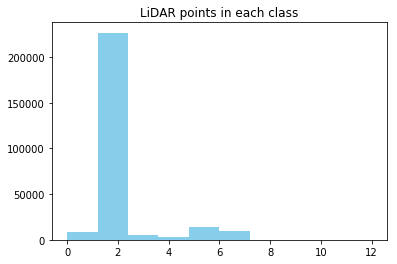

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(tt_area.Classification, color = 'skyblue')

plt.title('LiDAR points in each class')

plt.show()

We can observe that the vast majority of values classify as Ground(2), so we are dealing with a disproportionate ratio of observations in each class, that will obviously lower our measures performance. There are also no 1 and 8+ classes.

### 1.2 Data sampling

We will use __down-sampling__ for majority class - Ground(2), and __up-sampling__ for other classes, setting the number of samples to match __5000 features__ for all categories.

We will use the scheme of Up-sample Minority Class and Down-sample Majority Class from  https://elitedatascience.com/imbalanced-classes.

First we have to split our data to __train / test__ datasets in order not to interfere with further model accuracy measurement on test data.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [18]:
X = tt_area.iloc[:,0:8]
X.head(5)

,Z,R,G,B,ScanAngleRank,NumberOfReturns,ReturnNumber,Intensity
0,49.340000,124,124,112,-25.0,1.0,1.0,64.0
1,49.320000,124,125,115,-25.0,1.0,1.0,60.0
2,49.310001,123,124,113,-25.0,1.0,1.0,62.0
3,49.340000,122,122,112,-25.0,1.0,1.0,64.0
4,49.320000,122,122,112,-25.0,1.0,1.0,70.0


In [19]:
y = tt_area.iloc[:,8]
y.head(5)

0    12.0
1    12.0
2    12.0
3    12.0
4    12.0
Name: Classification, dtype: float64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

Next we concatenate our X_train and y_train data in order to handle our imbalanced classes.

In [21]:
tt_area_train = pd.concat([X_train, y_train], axis=1, join='inner')
print(tt_area_train.head(5))

                Z    R    G   B  ScanAngleRank  NumberOfReturns  ReturnNumber  \
241629  71.370003   88   88  86            1.0              2.0           1.0   
133546  55.290001  102   94  81            6.0              1.0           1.0   
94034   56.139999   28   43  50            0.0              1.0           1.0   
13925   49.610001  103  111  99          -13.0              1.0           1.0   
201849  52.430000   55   64  69           -9.0              1.0           1.0   

        Intensity  Classification  
241629       18.0             5.0  
133546      117.0             2.0  
94034        84.0             2.0  
13925        80.0             2.0  
201849       70.0             2.0  


In [22]:
print(tt_area_train.Classification.value_counts()) # train data imbalanced classes

2.0     151851
5.0       9416
6.0       6723
0.0       6082
3.0       3742
4.0       1969
12.0       124
7.0          3
Name: Classification, dtype: int64


In [23]:
random_state = 123
n_samples = 25000

In [24]:
tt_area_majority_2 = tt_area_train[tt_area_train.Classification==2] # extraction of Ground features

In [25]:
tt_area_majority_2_upsampled = resample(tt_area_majority_2, 
                                 replace=False,              # sample without replacement
                                 n_samples=n_samples,        # n_samples chosen for down-sampling
                                 random_state=random_state)  # reproducible results

In [26]:
tt_area_minority_0 = tt_area_train[tt_area_train.Classification==0] # extraction of Never classified features
tt_area_minority_3 = tt_area_train[tt_area_train.Classification==3] # extraction of Low Vegetation features
tt_area_minority_4 = tt_area_train[tt_area_train.Classification==4] # extraction of Medium Vegetation features
tt_area_minority_5 = tt_area_train[tt_area_train.Classification==5] # extraction of High Vegetation features
tt_area_minority_6 = tt_area_train[tt_area_train.Classification==6] # extraction of Building features
tt_area_minority_7 = tt_area_train[tt_area_train.Classification==7] # extraction of Noise features
tt_area_minority_12 = tt_area_train[tt_area_train.Classification==12] # extraction of Overlap (Reserved) features

In [27]:
tt_area_minority_0_upsampled = resample(tt_area_minority_0, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tt_area_minority_3_upsampled = resample(tt_area_minority_3, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tt_area_minority_4_upsampled = resample(tt_area_minority_4, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tt_area_minority_5_upsampled = resample(tt_area_minority_5, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tt_area_minority_6_upsampled = resample(tt_area_minority_6, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tt_area_minority_7_upsampled = resample(tt_area_minority_7, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

tt_area_minority_12_upsampled = resample(tt_area_minority_12, 
                                 replace=True,               # sample with replacement
                                 n_samples=n_samples,        # to match majority class
                                 random_state=random_state)  # reproducible results

Next we join our training sampled data together.

In [28]:
tt_area_train_sampled = pd.concat([tt_area_minority_0_upsampled, tt_area_majority_2_upsampled, 
                                     tt_area_minority_3_upsampled, tt_area_minority_4_upsampled, 
                                     tt_area_minority_5_upsampled, tt_area_minority_6_upsampled, 
                                     tt_area_minority_7_upsampled, tt_area_minority_12_upsampled ])

So now the new train dataset has more observations than the original and the ratio of the all classes is now 1:1.

In [29]:
tt_area_train_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 155302 to 164
Data columns (total 9 columns):
Z                  200000 non-null float64
R                  200000 non-null int64
G                  200000 non-null int64
B                  200000 non-null int64
ScanAngleRank      200000 non-null float64
NumberOfReturns    200000 non-null float64
ReturnNumber       200000 non-null float64
Intensity          200000 non-null float64
Classification     200000 non-null float64
dtypes: float64(6), int64(3)
memory usage: 15.3 MB


In [30]:
tt_area_train_sampled.Classification.value_counts() #we now have 200 000 points in our training dataset

7.0     25000
12.0    25000
5.0     25000
6.0     25000
4.0     25000
3.0     25000
2.0     25000
0.0     25000
Name: Classification, dtype: int64

In [31]:
X_train = tt_area_train_sampled.iloc[:, :8]
y_train = tt_area_train_sampled.iloc[:, 8]

In [32]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

In [33]:
X_train = mm.fit_transform(X_train)
X_test = mm.fit_transform(X_test)

d:\miniconda3\envs\hm1016\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
d:\miniconda3\envs\hm1016\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### 1.3 XGBoost - default

In next step we will use an advanced implementation of gradient boosting algorithm - __XGBoost__.

First with default settings (we will work only with scaled data from now on).

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [35]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_train)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(model_xgb)

Accuracy: 82.80%
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [36]:
y_pred = model_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 53.08%


Over 71% accuracy is not bad, but with 12% accuracy decrease we could already encounter overfitting problem.


### 1.4 XGBoost - tuning


Below we will tune XGBoost parameters and see if our accuracy score on train and test data got better.

We will make use of https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ guide as optimization scheme.

The various steps to be performed are:

1. Choosing default __learning rate__ and __number of trees__
2. Tune __max_depth__ and __min_child_weight__
3. Tune __gamma__
4. Tune __subsample__ and __colsample_bytree__
5. Tuning of __regularization parameters__
6. Reducing __learning rate__ and adding __more trees__.

Let us look at a more detailed step by step approach.

First we will set default values for:
* learning rate - 0.1,
* number of trees - 100,

which will be changed after remaining parameters optimalization.

Next we will set __GridSearchCV__ with __5 cross-validation__ value and tune __max_depth__ and __min_child_weight__ as they will most likely have the highest impact on model outcome.

In [37]:
from sklearn.model_selection import GridSearchCV


params = {
    'max_depth':[5,10,20],
    'min_child_weight':[1,3,5]
}

gscv1 = GridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                            colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                                            missing=None, n_estimators=100, n_jobs=1, nthread=None, 
                                            objective='multi:softprob', random_state=0, reg_alpha=0, reg_lambda=1,
                                            scale_pos_weight=1, seed=None, silent=True, subsample=1,tree_method='gpu_hist'),
                                            param_grid = params, cv=5, verbose=100)

gscv1.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .... max_depth=5, min_child_weight=1, score=0.8687, total=  11.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.7s remaining:    0.0s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .... max_depth=5, min_child_weight=1, score=0.8732, total=  10.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.4s remaining:    0.0s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .. max_depth=5, min_child_weight=1, score=0.871225, total=  10.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.8s remaining:    0.0s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .. max_depth=5, min_child_weight=1, score=0.871275, total=  10.1s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

[CV] . max_depth=20, min_child_weight=3, score=0.986925, total= 1.4min
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 23.1min remaining:    0.0s
[CV] max_depth=20, min_child_weight=3 ................................
[CV] .. max_depth=20, min_child_weight=3, score=0.98675, total= 1.5min
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 24.5min remaining:    0.0s
[CV] max_depth=20, min_child_weight=3 ................................
[CV] ... max_depth=20, min_child_weight=3, score=0.9869, total= 1.5min
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 26.0min remaining:    0.0s
[CV] max_depth=20, min_child_weight=3 ................................
[CV] . max_depth=20, min_child_weight=3, score=0.986975, total= 1.5min
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 27.4min remaining:    0.0s
[CV] max_depth=20, min_child_weight=5 ................................
[CV] . max_depth=20, min_child_weight=5, score=0.985025, total= 1.3min
[Parallel(n_jobs=1)]: Done  41 out of  41

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 20], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=100)

We see 20 as the optimal value for __max_depth__ and  for __min_child_weight__ and because these are our extreme values we will search for more precise values.

In [ ]:
s = gscv1.grid_scores_.copy()
s.sort(key= lambda x: x[1],reverse=True)
s

# 此处可以可视化
s = gscv1.cv_results_.copy()
means = s['mean_test_score']
params = s['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))
s

In [ ]:
xgb = XGBClassifier(**gscv1.best_params_,tree_method='gpu_hist')
params = {'max_depth': [20,30,40,50],
         'min_child_weight': [1,2]}
gscv2 = GridSearchCV(param_grid=params, estimator=xgb,cv=5, verbose=100)
gscv2.fit(X_train,y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=20, min_child_weight=1 ................................
[CV] . max_depth=20, min_child_weight=1, score=0.988925, total= 2.0min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[CV] max_depth=20, min_child_weight=1 ................................
[CV] ... max_depth=20, min_child_weight=1, score=0.9891, total= 1.9min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s
[CV] max_depth=20, min_child_weight=1 ................................
[CV] .. max_depth=20, min_child_weight=1, score=0.98815, total= 1.9min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.8min remaining:    0.0s
[CV] max_depth=20, min_child_weight=1 ................................
[CV] . max_depth=20, min_child_weight=1, score=0.988175, total= 2.0min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

In [ ]:
s = gscv2.grid_scores_.copy()
s.sort(key= lambda x: x[1],reverse=True)
s

We will go one step deeper once more and look for optimum values for max_depth.

In [ ]:
xgb = XGBClassifier(**gscv2.best_estimator_.get_params())
params = {'max_depth': [50,60,70,80]
         }
gscv3 = GridSearchCV(param_grid=params, estimator=xgb,cv=5, verbose=100)
gscv3.fit(X_train,y_train)


In [ ]:
s = gscv3.grid_scores_.copy()
s.sort(key= lambda x: x[1],reverse=True)
s

We see that picking __50 max_depth__ value was the right way to go. So now we've got the optimum values of __50__ for __max_depth__ and __1__ for __min_child_weight__.

Subsequently we will tune __gamma value__ using the parameters already tuned above.

In [ ]:
xgb = XGBClassifier(**gscv3.best_estimator_.get_params())
params = {'gamma':[0.0,0.1,0.2,0.3,0.4]
          
         }
gscv4 = GridSearchCV(param_grid=params, estimator=xgb,cv=5, verbose=100)
gscv4.fit(X_train,y_train)


In [ ]:
s = gscv4.grid_scores_.copy()
s.sort(key= lambda x: x[1],reverse=True)
s

We've got the optimum value of __0.0__ for __gamma__ parameter.

Next we will tune __subsample__ and __colsample_bytree__ with values 0.6, 0.7, 0.8, 0.9 for both.

In [ ]:
xgb = XGBClassifier(**gscv4.best_estimator_.get_params())
params = {'subsample':[0.6,0.7,0.8,0.9],
         'colsample_bytree':[0.6,0.7,0.8,0.9]

         }
gscv5 = GridSearchCV(param_grid=params, estimator=xgb,cv=5, verbose=100)
gscv5.fit(X_train,y_train)


In [ ]:
s = gscv5.grid_scores_.copy()
s.sort(key= lambda x: x[1],reverse=True)
s

We see that __colsample_bytree__: 0.6 and __subsample__: 0.9 were the most optimum values.

Now we will apply regularization (__reg_alpha, reg_lambda__) to reduce overfitting.

In [ ]:
xgb = XGBClassifier(**gscv5.best_estimator_.get_params())
params = {'reg_alpha':[1e-5, 1e-2, 0, 0.1, 1, 100],
          
        }

gscv6 = GridSearchCV(param_grid=params, estimator=xgb,cv=5, verbose=100)
gscv6.fit(X_train,y_train)


In [ ]:
s = gscv6.grid_scores_.copy()
s.sort(key= lambda x: x[1],reverse=True)
s

We've got an extreme value of 1e-05 so we will do more investigation.

In [ ]:
xgb = XGBClassifier(**gscv6.best_estimator_.get_params())
params = {'reg_alpha':[1e-9, 1e-7, 1e-5, 1e-3]
          
        }

gscv7 = GridSearchCV(param_grid=params, estimator=xgb,cv=5, verbose=100)
gscv7.fit(X_train,y_train)
s = gscv7.grid_scores_.copy()
s.sort(key= lambda x: x[1],reverse=True)
s

Next we focus on __reg_lambda__.

In [ ]:
xgb = XGBClassifier(**gscv7.best_estimator_.get_params())
params = {'reg_lambda':[1e-5, 1e-2, 0, 0.1, 1, 100],
          
        }

gscv8 = GridSearchCV(param_grid=params, estimator=xgb,cv=5, verbose=100)
gscv8.fit(X_train,y_train)
s = gscv8.grid_scores_.copy()
s.sort(key= lambda x: x[1],reverse=True)
s

As well as in reg_alpha we've got the extreme value of 1e-05 so we do more searching.

In [ ]:
xgb = XGBClassifier(**gscv8.best_estimator_.get_params())
params = {'reg_lambda':[1e-9, 1e-7, 1e-5, 1e-3]
          
        }

gscv9 = GridSearchCV(param_grid=params, estimator=xgb,cv=5, verbose=100)
gscv9.fit(X_train,y_train)
s = gscv9.grid_scores_.copy()
s.sort(key= lambda x: x[1],reverse=True)
s

We see that __creg_alpha__: 1e-05 and __reg_lambda__: 0.001 were the most optimum values.

Finally we've achieved our optimal XGBoost algorithm.

In [ ]:
print(gscv9.best_estimator_)

Next we should lower the __learning rate__ to 0.01 and add more __trees__ - 1000.

In [ ]:
best_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                           colsample_bytree=0.6, gamma=0.0, learning_rate=0.01,
                           max_delta_step=0, max_depth=50, min_child_weight=1, missing=None,
                           n_estimators=1000, n_jobs=1, nthread=None,
                           objective='multi:softprob', random_state=0, reg_alpha=1e-07,
                           reg_lambda=0.001, scale_pos_weight=1, seed=None, silent=True,
                           subsample=0.9)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_train)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
y_pred = best_model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

A score of over 87%.

Summarizing our tuned XGBoost algorithm got the best score for training and test datasets.

## 2.Test dataset

### 2.1 Data analysis

Test area consists of 46 973 LiDAR points located over 9 896 square meters.

<img src='img/Zakres2_2d.jpg' width="80%">
<img src='img/Zakres2_3d.jpg' width="80%">



In [ ]:
t_area = pd.read_csv('data/01.Test_Area.csv', header=0, delimiter=' ')

In [ ]:
t_area.info()

In [ ]:
t_area.isnull().sum()

We can see that in test area there are also only numerical features and that there are no null values within all data, so we can proceed with further analysis.

In [ ]:
t_area.nunique()

In [ ]:
t_area.describe()

In [ ]:
t_area = t_area.drop(['PointSourceId', 'ScanDirectionFlag', 'X', 'Y'], axis = 1)

In [ ]:
X2 = t_area.iloc[:,0:8]
y2 = t_area.iloc[:,8]

In [ ]:
X2.head(5)

In [ ]:
y2.head(5)

In [ ]:
np.unique(t_area.Classification, return_counts=True)

In [ ]:
plt.hist(t_area.Classification, color = 'skyblue')

plt.title('LiDAR points in each class')

plt.show()

In [ ]:
X2 = mm.fit_transform(X2) #we scale our data as in the first train/test area

### 2.2 XGBoost - default

In [ ]:
y2_pred = model_xgb.predict(X2)
predictions2 = [round(value) for value in y2_pred]
accuracy = accuracy_score(y2, predictions2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

### 2.3 XGBoost - tuned

In [ ]:
y2_pred = best_model.predict(X2)
predictions2 = [round(value) for value in y2_pred]
accuracy = accuracy_score(y2, predictions2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Only 54% ! So summarizing accuracies on X2, y2 test areas were really low in comparisson to X_test and y_test data from train/test area.

We will split our test area dataset to train, test data to see how our optimized XGBoost model works fitted on X2_train, y2_train data.

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.33)
X2_train = mm.fit_transform(X2_train)
X2_test = mm.fit_transform(X2_test)

In [ ]:
best_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                           colsample_bytree=0.6, gamma=0.0, learning_rate=0.01,
                           max_delta_step=0, max_depth=50, min_child_weight=1, missing=None,
                           n_estimators=1000, n_jobs=1, nthread=None,
                           objective='multi:softprob', random_state=0, reg_alpha=1e-07,
                           reg_lambda=0.001, scale_pos_weight=1, seed=None, silent=True,
                           subsample=0.9)

best_model.fit(X2_train, y2_train)
y2_pred = best_model.predict(X2_train)
predictions = [round(value) for value in y2_pred]
accuracy = accuracy_score(y2_train, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

We have achieved perfect score on train test area.

In [ ]:
y2_pred = best_model.predict(X2_test)
predictions = [round(value) for value in y2_pred]
accuracy = accuracy_score(y2_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))t

And almost 95% on test dataset! In conclusion two factors maybe to blame here.

First the chosen features were not optimal and we should try a pick other than __Univariate Selection__.

The second is that we only had one train/test area and our test area may have varied too much to achieve good result. With better hardware capabilities we could have chosen over a dozen of train/test areas and fit combined data into our algorithm.

To wrap things up there will be consecutive notebook __"02. XGBoost for Aerial LiDAR Data Classification with extended training dataset"__ where __XGBoost__ algorithm  will be trained an fit on __6 training areas__.